In [1]:
import numpy as np
from matplotlib import pyplot as plt

import loki
from loki.libloki.configs import PulsarSearchConfig
from loki.libloki.ffa import FFAPlan
from loki.libloki.prune import PruningManager
from pyloki.config import ParamLimits
from pyloki.core.taylor import generate_branching_pattern
from pyloki.detection import thresholding
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import PruningStatsPlotter, ScatteredPeriodogram
from pyloki.prune import prune_dyp_tree
from pyloki.simulation.pulse import PulseSignalConfig

tobs = 1073.741824


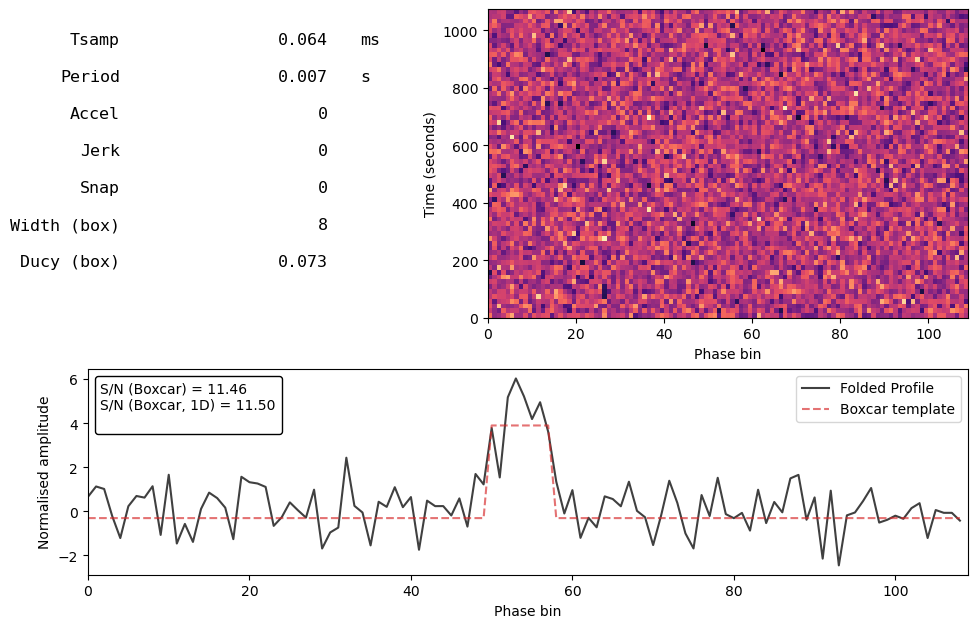

In [2]:
pulsar_period = 0.007
dt = 64e-6
nsamps = 2**24
mod_kwargs = {"p_orb": 1200, "psi": np.pi/4, "m_c": 10}
cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=11.5, ducy=0.1,
                        mod_kwargs=mod_kwargs, mod_type = "circular")
print(f"tobs = {cfg.tobs}")
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs, mod_type = "circular")
plt.show()

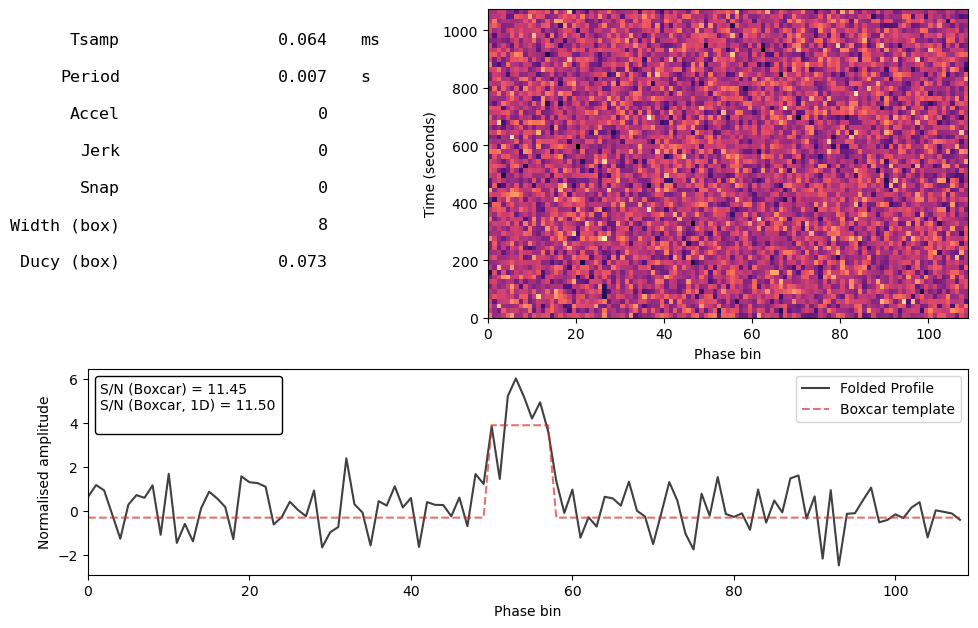

In [3]:
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=cfg.mod_func.to_derivatives_series(n=15), mod_type="derivative_series")
plt.show()

In [4]:
tol_bins = 1 
fold_bins = 64
p = ParamLimits.from_circular(1 / 0.007, 1100, 15, m_p=1.4, poly_order=4)
print(f"Param limits: {p.limits}")
bseg_brute = cfg.nsamps // 8192
bseg_ffa = cfg.nsamps // 128
search_cfg = PulsarSearchConfig(nsamps=cfg.nsamps, tsamp=cfg.dt, nbins=fold_bins, tol_bins=tol_bins, param_limits=p.limits,
                                bseg_brute=bseg_brute, bseg_ffa=bseg_ffa, prune_poly_order=4, nthreads=4, ducy_max=0.2, wtsp=1.1,
                                use_fft_shifts=True)
plan = FFAPlan(search_cfg)
branching_pattern = plan.generate_branching_pattern()
branching_pattern

Param limits: [(np.float64(-0.3951208285588826), np.float64(0.3951208285588826)), (np.float64(-69.17397628208265), np.float64(69.17397628208265)), (np.float64(-12110.31828447648), np.float64(12110.31828447648)), (np.float64(141.8468445359672), np.float64(143.86744117831853))]


array([8.        , 3.        , 2.        , 3.        , 3.        ,
       1.        , 6.        , 3.        , 1.        , 1.        ,
       3.        , 1.        , 1.        , 3.        , 6.        ,
       3.        , 1.        , 1.        , 3.        , 1.        ,
       1.        , 1.        , 3.        , 1.        , 3.        ,
       3.        , 1.        , 1.        , 1.        , 1.        ,
       2.        , 1.        , 3.        , 3.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 3.        ,
       1.        , 1.        , 3.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 1.        ,
       1.        , 1.        , 2.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

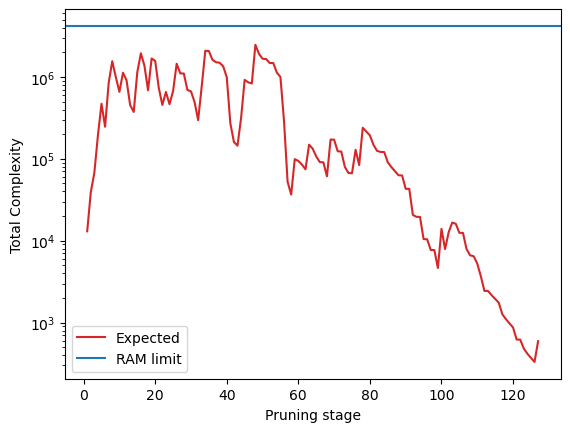

In [5]:
thresholds = np.array([1.5, 1.7, 2.2, 2.1, 2.4, 2.8, 3. , 3.1, 3.2, 3.3, 3.5, 3.4, 3.7,
       4.1, 4.2, 4.3, 4.3, 4.5, 4.4, 4.2, 4.6, 4.7, 4.9, 4.9, 5.1, 5.1,
       5.1, 4.7, 5.1, 4.9, 5.4, 5.5, 5.4, 5.3, 5. , 5.3, 5.2, 5. , 5.1,
       5.3, 5.8, 5.9, 5.8, 5.9, 5.7, 5.7, 5.6, 5.4, 5.7, 5.7, 5.5, 5.6,
       5.2, 5.7, 5.7, 6.2, 6.6, 6.6, 6.5, 6.4, 6.4, 6.4, 6. , 6.3, 6.4,
       6.4, 6.2, 6.5, 6.4, 6.2, 6.5, 6.3, 6.6, 6.6, 6.4, 6.7, 6.8, 6.7,
       6.7, 6.7, 6.8, 6.8, 6.7, 6.5, 6.8, 6.8, 6.8, 6.8, 6.6, 6.9, 6.6,
       7.1, 7. , 6.8, 7.2, 7. , 7.2, 6.9, 7.3, 6.9, 7.4, 7.4, 7.4, 7.3,
       7.4, 7.1, 7.5, 7.5, 7.4, 7.5, 7.6, 7.7, 7.4, 7.6, 7.6, 7.6, 7.7,
       7.7, 7.7, 7.7, 7.8, 7.5, 7.8, 7.8, 7.8, 7.8, 7.8])
thresh_state = thresholding.evaluate_scheme(thresholds, branching_pattern, ref_ducy=0.1, nbins=64,
                                            ntrials=1024, snr_final=9.7, ducy_max=0.2, wtsp=1.1)
x = np.arange(1, len(branching_pattern) + 1)
nparam_vol = plan.ncoords[-1]
plt.semilogy(x, np.array(thresh_state.get_info("complexity")) * nparam_vol, label="Expected", c="tab:red")
plt.axhline(2**22, label="RAM limit", c="tab:blue")
plt.xlabel("Pruning stage")
plt.ylabel("Total Complexity")
plt.legend()
plt.show()

In [6]:
prn_manager = PruningManager(search_cfg, thresholds, n_runs=16, max_sugg=2**22, batch_size=1024)
prn_manager.execute(tim_data.ts_e, tim_data.ts_v, outdir="pruning_results/circular_test/", file_prefix="test_circular", kind="taylor", show_progress=False)

[2025-08-20 21:43:43.452] [info] PruningManager: Initializing with FFA
[2025-08-20 21:43:43.462] [info] FFACOMPLEX Memory Usage: 0.10 GB (1 buffers) + 0.00 GB (coords)
[2025-08-20 21:43:43.471] [info] FFACOMPLEX::execute started
[2025-08-20 21:43:43.471] [info] FFACOMPLEX::initialize started
[2025-08-20 21:43:43.862] [info] FFACOMPLEX::initialize took 390 ms
[2025-08-20 21:43:43.876] [info] FFACOMPLEX::execute took 405 ms
[2025-08-20 21:43:43.878] [info] Starting Pruning for 16 runs, with 4 threads
[2025-08-20 21:43:44.493] [info] Pruning run 000: Memory Usage: 2.70 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 21:43:44.494] [info] Pruning run 000: initialized
[2025-08-20 21:43:44.580] [info] Pruning run 017: Memory Usage: 2.70 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 21:43:44.581] [info] Pruning run 017: initialized
[2025-08-20 21:43:44.606] [info] Pruning run 008: Memory Usage: 2.70 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 21:43:44.607] [info] Pruning run 008

In [7]:
result_file = "pruning_results/circular_test/test_circular_pruning_nstages_128_results.h5"
pgram = ScatteredPeriodogram.load(result_file)
param_true = cfg.mod_func.to_derivatives()
snap_true = param_true["snap"]
jerk_true = param_true["jerk"]
acc_true = param_true["acc"]
freq_true = cfg.freq
print(f"True params, s: {snap_true:.3f}, j: {jerk_true:.3f}, a: {acc_true:.3f}, f: {freq_true:.10f}")
print(pgram.get_summary_cands(10, run_id=None))

True params, s: 0.178, j: -33.920, a: -6478.243, f: 142.8571428571
Top candidates:
dparams: dsnap: 0.0001204453067, djerk: 0.007028804174, daccel: 0.8462713091, dfreq: 2.910383046e-05
Run: 051_07, S/N: 9.49, snap: 0.17891, jerk: -34.1209, accel: -6518.91, freq: 142.267604
Run: 051_07, S/N: 9.48, snap: 0.17891, jerk: -34.1209, accel: -6518.91, freq: 142.267575
Run: 051_07, S/N: 9.43, snap: 0.17893, jerk: -34.1268, accel: -6519.61, freq: 142.267563
Run: 051_07, S/N: 9.31, snap: 0.17893, jerk: -34.1268, accel: -6519.61, freq: 142.267534
Run: 051_07, S/N: 9.27, snap: 0.17676, jerk: -34.2079, accel: -6510.60, freq: 142.267136
Run: 051_07, S/N: 9.26, snap: 0.17676, jerk: -34.2079, accel: -6510.60, freq: 142.267107
Run: 051_07, S/N: 9.17, snap: 0.17899, jerk: -34.1158, accel: -6517.04, freq: 142.267547
Run: 051_07, S/N: 9.15, snap: 0.17899, jerk: -34.1158, accel: -6517.04, freq: 142.267576
Run: 051_07, S/N: 9.12, snap: 0.17886, jerk: -34.1234, accel: -6519.85, freq: 142.267501
Run: 051_07, S/

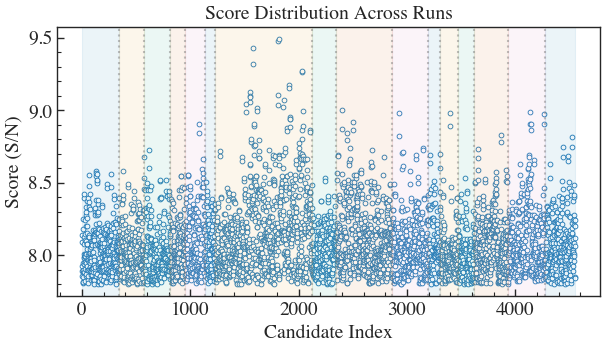

In [8]:
pgram.plot_scores(kind="scatter", run_id=None); plt.show()

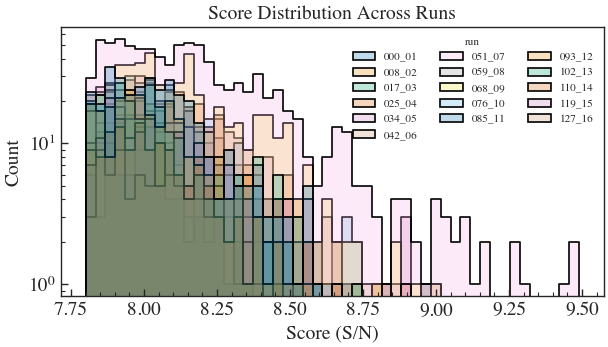

In [9]:
pgram.plot_scores(kind="hist", run_id=None); plt.show()

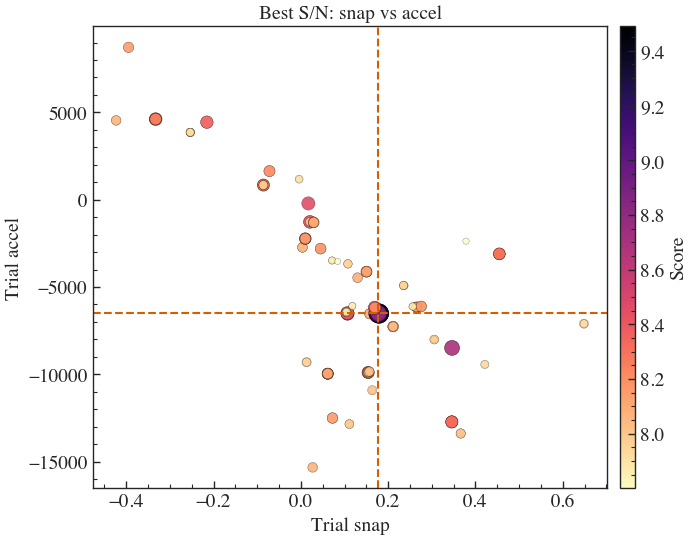

In [12]:
pgram.plot_correlation("snap", "accel", true_values={"snap": snap_true, "accel": acc_true}, run_id="051_07"); plt.show()

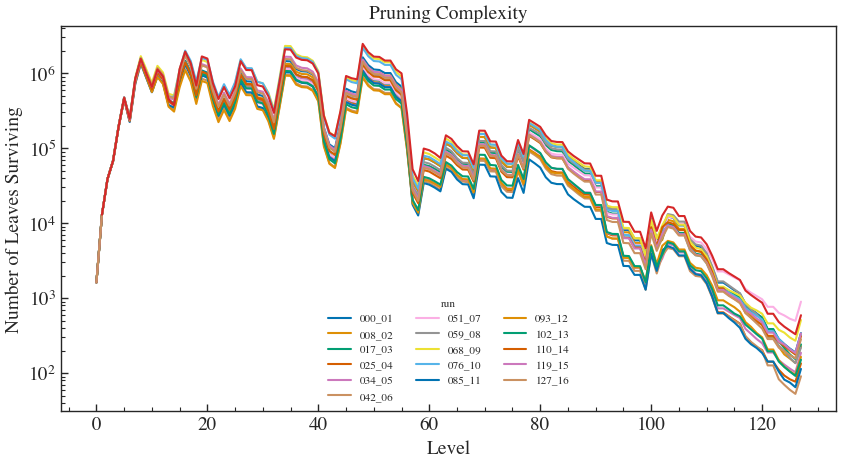

In [13]:
pstats = PruningStatsPlotter.load(result_file)
fig = pstats.plot_level_stats(run_id=None)
x = np.arange(1, len(branching_pattern) + 1)
ax_list = fig.axes
ax_list[0].plot(x, np.array(thresh_state.get_info("complexity")) * nparam_vol, label="Sim", c="tab:red")
plt.show()